# EDA Projects
This notebook contains various EDA projects on the flights and weather data

In [0]:
blob_container = "w261-scrr" # The name of your container created in https://portal.azure.com
storage_account = "midsw261rv" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261scrr" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261scrrkey" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)


In [0]:
import pyspark
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import airporttime
from datetime import datetime, timedelta
import pandas as pd; pd.set_option('max_columns', 6)  # Unclutter display.
import altair as alt
from vega_datasets import data
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.sql.types import StringType, BooleanType
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np

import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


In [0]:
%run "../libs/airlines_data"

In [0]:
airlines_train = get_full_airlines_data_train()

In [0]:
%run "../libs/time_based_features"

## EDA 1: Geoplot of airline data with delay percentages

In [0]:
airport_codes = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/airport_codes_csv.csv")
codes_cols = ['ident', 'elevation_ft', 'iata_code', 'coordinates']
airport_codes = airport_codes.select(*codes_cols).filter(airport_codes.iata_code != 'null').cache()

In [0]:
# grouping by airports, calculating percentage of flights that were delayed, and joining airport_codes for coordinates
airport_agg = airlines_train.groupby("ORIGIN", "MONTH").agg(F.sum("DEP_DEL15"), F.count("DEP_DEL15")) \
                                                   .withColumn("DEL_PERCENT", (F.col("sum(DEP_DEL15)") / F.col("count(DEP_DEL15)")) * F.lit(100)) \
                                                   .join(airport_codes, F.col("ORIGIN") == airport_codes.iata_code, how="left") \
                                                   .withColumn('Longitude', F.split(F.col("coordinates"), ", ").getItem(0).cast("double")) \
                                                   .withColumn('Latitude', F.split(F.col("coordinates"), ", ").getItem(1).cast("double")) \
                                                   .drop(*["iata_code", "coordinates"]).cache()
airport_agg_pd = airport_agg.toPandas()
# display(airport_agg)

In [0]:
# it's blasphemy in this class, I know, but it's just for one lil viz so it's okay
airport_agg_pd = airport_agg.toPandas()

In [0]:
print(airport_agg_pd["DEL_PERCENT"].mean(), airport_agg_pd["DEL_PERCENT"].std())

16.743800138459054 9.523463712354486

In [0]:
def delay_geoplot(df_pd, month=None):
    months = ["Jan.", "Feb.", "Mar.", "Apr.", "May", "Jun.",
              "Jul.", "Aug.", "Sep.", "Oct.", "Nov.", "Dec."]
    states = alt.topo_feature(data.us_10m.url, "states")
    background = alt.Chart(states).mark_geoshape(
      stroke="black",
      fill="white",
      strokeOpacity=1.0
    ).project("albersUsa")

    points = alt.Chart(df_pd).mark_circle().encode(
      latitude = "Latitude:Q",
      longitude = "Longitude:Q",
      opacity = alt.value(0.8),
      size = alt.Size("DEL_PERCENT:Q", title="Percentage of Flights Delayed")
    ).project("albersUsa")

    text = alt.Chart(df_pd).mark_text().encode(
      latitude = "Latitude:Q",
      longitude = "Longitude:Q",
      opacity = alt.value(0.75),
      text = alt.Text("ORIGIN"),
      size = alt.value(10)
    ).project("albersUsa")

    chart = (background + points).properties(
      title=f"Airport Locations and Delay Frequency for {months[month-1]}",
      width=800,
      height=400,
    )
    return chart

In [0]:
charts = []
stats = {}
# filtering by month for seasonality, grouping by airports, calculating percentage of flights that were delayed, and joining airport_codes for coordinates
for month in range(1, 13):
    month = str(month)
    airport_agg = airlines_train.filter(F.col("MONTH") == month) \
                                .groupby("ORIGIN").agg(F.sum("DEP_DEL15"), F.count("DEP_DEL15")) \
                                .withColumn("DEL_PERCENT", (F.col("sum(DEP_DEL15)") / F.col("count(DEP_DEL15)")) * F.lit(100)) \
                                .join(airport_codes, F.col("ORIGIN") == airport_codes.iata_code, how="left") \
                                .withColumn('Longitude', F.split(F.col("coordinates"), ", ").getItem(0).cast("double")) \
                                .withColumn('Latitude', F.split(F.col("coordinates"), ", ").getItem(1).cast("double")) \
                                .drop(*["iata_code", "coordinates"]).cache()
    # converting to Pandas DataFrame for Altair plot
    airport_agg_pd = airport_agg.toPandas()
    avg = airport_agg_pd["DEL_PERCENT"].mean()
    std = airport_agg_pd["DEL_PERCENT"].std()
    stats[month] = (avg, std)
    
    # altair geoplot
    charts.append(delay_geoplot(airport_agg_pd, int(month)))

In [0]:
stats

Out[74]: {'1': (18.030026510875295, 8.700883794618226),
 '2': (16.989579927034036, 5.810051699655406),
 '3': (15.470580812802693, 6.883459170169355),
 '4': (13.998387711029022, 6.374317333754785),
 '5': (15.10452473445193, 7.205110959373655),
 '6': (17.92676744455985, 7.575720602714528),
 '7': (18.121638222566656, 7.467738078803725),
 '8': (17.35883422096319, 7.343706177537524),
 '9': (12.192511295670931, 5.344434083543937),
 '10': (12.641289934403298, 5.566203754496222),
 '11': (13.845398214814795, 7.1842246869340665),
 '12': (18.24892988255561, 6.3007988685743666)}

In [0]:
charts[5] | charts[8]

Out[75]:

In [0]:
# Altair boxplot for delay percentage by month
airport_agg_pd["MONTH"] = airport_agg_pd["MONTH"].astype("int")
chart = alt.Chart(airport_agg_pd).mark_boxplot(extent=1.5).encode(
    x = alt.X("MONTH:O", title="Month of Year"),
    y = alt.Y("DEL_PERCENT:Q", title="Percentage of Flights Delayed")
).properties(
    width=400,
    height=300
)
chart

Out[111]:

## EDA 2: Holidays

In [0]:
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/lana.elauria@berkeley.edu/US_Holiday_Dates__2004_2021_.csv").cache()
display(df1)

Date Holiday WeekDay Month Day Year Importance 7/4/04 4th of July Sunday 7 4 2004 2 7/4/05 4th of July Monday 7 4 2005 2 7/4/06 4th of July Tuesday 7 4 2006 2 7/4/07 4th of July Wednesday 7 4 2007 2 7/4/08 4th of July Friday 7 4 2008 2 7/4/09 4th of July Saturday 7 4 2009 2 7/4/10 4th of July Sunday 7 4 2010 2 7/4/11 4th of July Monday 7 4 2011 2 7/4/12 4th of July Wednesday 7 4 2012 2 7/4/13 4th of July Thursday 7 4 2013 2 7/4/14 4th of July Friday 7 4 2014 2 7/4/15 4th of July Saturday 7 4 2015 2 7/4/16 4th of July Monday 7 4 2016 2 7/4/17 4th of July Tuesday 7 4 2017 2 7/4/18 4th of July Wednesday 7 4 2018 2 7/4/19 4th of July Thursday 7 4 2019 2 7/4/20 4th of July Saturday 7 4 2020 2 7/4/21 4th of July Sunday 7 4 2021 2 12/25/04 Christmas Day Saturday 12 25 2004 2 12/25/05 Christmas Day Sunday 12 25 2005 2 12/25/06 Christmas Day Monday 12 25 2006 2 12/25/07 Christmas Day Tuesday 12 25 2007 2 12/25/08 Christmas Day Thursday 12 25 2008 2 12/25/09 Christmas Day Friday 12 25 2009 2 12/25/10 Christmas Day Saturday 12 25 2010 2 12/25/11 Christmas Day Sunday 12 25 2011 2 12/25/12 Christmas Day Tuesday 12 25 2012 2 12/25/13 Christmas Day Wednesday 12 25 2013 2 12/25/14 Christmas Day Thursday 12 25 2014 2 12/25/15 Christmas Day Friday 12 25 2015 2 12/25/16 Christmas Day Sunday 12 25 2016 2 12/25/17 Christmas Day Monday 12 25 2017 2 12/25/18 Christmas Day Tuesday 12 25 2018 2 12/25/19 Christmas Day Wednesday 12 25 2019 2 12/25/20 Christmas Day Friday 12 25 2020 2 12/25/21 Christmas Day Saturday 12 25 2021 2 12/24/04 Christmas Eve Friday 12 24 2004 2 12/24/05 Christmas Eve Saturday 12 24 2005 2 12/24/06 Christmas Eve Sunday 12 24 2006 2 12/24/07 Christmas Eve Monday 12 24 2007 2 12/24/08 Christmas Eve Wednesday 12 24 2008 2 12/24/09 Christmas Eve Thursday 12 24 2009 2 12/24/10 Christmas Eve Friday 12 24 2010 2 12/24/11 Christmas Eve Saturday 12 24 2011 2 12/24/12 Christmas Eve Monday 12 24 2012 2 12/24/13 Christmas Eve Tuesday 12 24 2013 2 12/24/14 Christmas Eve Wednesday 12 24 2014 2 12/24/15 Christmas Eve Thursday 12 24 2015 2 12/24/16 Christmas Eve Saturday 12 24 2016 2 12/24/17 Christmas Eve Sunday 12 24 2017 2 12/24/18 Christmas Eve Monday 12 24 2018 2 12/24/19 Christmas Eve Tuesday 12 24 2019 2 12/24/20 Christmas Eve Thursday 12 24 2020 2 12/24/21 Christmas Eve Friday 12 24 2021 2 10/8/07 Columbus Day Monday 10 8 2007 0 10/8/12 Columbus Day Monday 10 8 2012 0 10/8/18 Columbus Day Monday 10 8 2018 0 10/9/06 Columbus Day Monday 10 9 2006 0 10/9/17 Columbus Day Monday 10 9 2017 0 10/10/05 Columbus Day Monday 10 10 2005 0 10/10/11 Columbus Day Monday 10 10 2011 0 10/10/16 Columbus Day Monday 10 10 2016 0 10/11/04 Columbus Day Monday 10 11 2004 0 10/11/10 Columbus Day Monday 10 11 2010 0 10/11/21 Columbus Day Monday 10 11 2021 0 10/12/09 Columbus Day Monday 10 12 2009 0 10/12/15 Columbus Day Monday 10 12 2015 0 10/12/20 Columbus Day Monday 10 12 2020 0 10/13/08 Columbus Day Monday 10 13 2008 0 10/13/14 Columbus Day Monday 10 13 2014 0 10/14/13 Columbus Day Monday 10 14 2013 0 10/14/19 Columbus Day Monday 10 14 2019 0 4/4/10 Eastern Easter Sunday 4 4 2010 0 4/8/07 Eastern Easter Sunday 4 8 2007 0 4/8/18 Eastern Easter Sunday 4 8 2018 0 4/11/04 Eastern Easter Sunday 4 11 2004 0 4/12/15 Eastern Easter Sunday 4 12 2015 0 4/15/12 Eastern Easter Sunday 4 15 2012 0 4/16/17 Eastern Easter Sunday 4 16 2017 0 4/19/20 Eastern Easter Sunday 4 19 2020 0 4/19/09 Eastern Easter Sunday 4 19 2009 0 4/20/14 Eastern Easter Sunday 4 20 2014 0 4/23/06 Eastern Easter Sunday 4 23 2006 0 4/24/11 Eastern Easter Sunday 4 24 2011 0 4/27/08 Eastern Easter Sunday 4 27 2008 0 4/28/19 Eastern Easter Sunday 4 28 2019 0 5/2/21 Eastern Easter Sunday 5 2 2021 0 5/1/05 Eastern Easter Sunday 5 1 2005 0 5/1/16 Eastern Easter Sunday 5 1 2016 0 5/5/13 Eastern Easter Sunday 5 5 2013 0 6/19/20 Juneteenth Friday 6 19 2020 0 6/19/21 Juneteenth Saturday 6 19 2021 0 6/19/04 Juneteenth Saturday 6 19 2004 0 6/19/05 Juneteenth Sunday 6 19 2005 0 6/19/06 Juneteenth Monday 6 19 2006

In [0]:
df1.write.parquet(f"{blob_url}/holidays")

In [0]:
for column in ["Month", "Day"]:
    df1 = df1.withColumn(column, when(length(col(column))<2, lpad(col(column), 2, "0")).otherwise(col(column)))
df1 = df1.withColumn("Date", concat(col("Year"), lit("-"), col("Month"), lit("-"), col("Day")))
df1 = df1.withColumn("Date_time", to_timestamp(df1.Date, "yyyy-mm-dd"))
df1 = df1.withColumn("Is_Holiday", 1).select('Date', 'Holiday', 'Date_time', 'Importance', 'Is_Holiday').cache()
display(df1)

Date Holiday WeekDay Month Day Year Importance Date_time 2004-07-04 4th of July Sunday 07 04 2004 2 2004-01-04T00:07:00.000+0000 2005-07-04 4th of July Monday 07 04 2005 2 2005-01-04T00:07:00.000+0000 2006-07-04 4th of July Tuesday 07 04 2006 2 2006-01-04T00:07:00.000+0000 2007-07-04 4th of July Wednesday 07 04 2007 2 2007-01-04T00:07:00.000+0000 2008-07-04 4th of July Friday 07 04 2008 2 2008-01-04T00:07:00.000+0000 2009-07-04 4th of July Saturday 07 04 2009 2 2009-01-04T00:07:00.000+0000 2010-07-04 4th of July Sunday 07 04 2010 2 2010-01-04T00:07:00.000+0000 2011-07-04 4th of July Monday 07 04 2011 2 2011-01-04T00:07:00.000+0000 2012-07-04 4th of July Wednesday 07 04 2012 2 2012-01-04T00:07:00.000+0000 2013-07-04 4th of July Thursday 07 04 2013 2 2013-01-04T00:07:00.000+0000 2014-07-04 4th of July Friday 07 04 2014 2 2014-01-04T00:07:00.000+0000 2015-07-04 4th of July Saturday 07 04 2015 2 2015-01-04T00:07:00.000+0000 2016-07-04 4th of July Monday 07 04 2016 2 2016-01-04T00:07:00.000+0000 2017-07-04 4th of July Tuesday 07 04 2017 2 2017-01-04T00:07:00.000+0000 2018-07-04 4th of July Wednesday 07 04 2018 2 2018-01-04T00:07:00.000+0000 2019-07-04 4th of July Thursday 07 04 2019 2 2019-01-04T00:07:00.000+0000 2020-07-04 4th of July Saturday 07 04 2020 2 2020-01-04T00:07:00.000+0000 2021-07-04 4th of July Sunday 07 04 2021 2 2021-01-04T00:07:00.000+0000 2004-12-25 Christmas Day Saturday 12 25 2004 2 2004-01-25T00:12:00.000+0000 2005-12-25 Christmas Day Sunday 12 25 2005 2 2005-01-25T00:12:00.000+0000 2006-12-25 Christmas Day Monday 12 25 2006 2 2006-01-25T00:12:00.000+0000 2007-12-25 Christmas Day Tuesday 12 25 2007 2 2007-01-25T00:12:00.000+0000 2008-12-25 Christmas Day Thursday 12 25 2008 2 2008-01-25T00:12:00.000+0000 2009-12-25 Christmas Day Friday 12 25 2009 2 2009-01-25T00:12:00.000+0000 2010-12-25 Christmas Day Saturday 12 25 2010 2 2010-01-25T00:12:00.000+0000 2011-12-25 Christmas Day Sunday 12 25 2011 2 2011-01-25T00:12:00.000+0000 2012-12-25 Christmas Day Tuesday 12 25 2012 2 2012-01-25T00:12:00.000+0000 2013-12-25 Christmas Day Wednesday 12 25 2013 2 2013-01-25T00:12:00.000+0000 2014-12-25 Christmas Day Thursday 12 25 2014 2 2014-01-25T00:12:00.000+0000 2015-12-25 Christmas Day Friday 12 25 2015 2 2015-01-25T00:12:00.000+0000 2016-12-25 Christmas Day Sunday 12 25 2016 2 2016-01-25T00:12:00.000+0000 2017-12-25 Christmas Day Monday 12 25 2017 2 2017-01-25T00:12:00.000+0000 2018-12-25 Christmas Day Tuesday 12 25 2018 2 2018-01-25T00:12:00.000+0000 2019-12-25 Christmas Day Wednesday 12 25 2019 2 2019-01-25T00:12:00.000+0000 2020-12-25 Christmas Day Friday 12 25 2020 2 2020-01-25T00:12:00.000+0000 2021-12-25 Christmas Day Saturday 12 25 2021 2 2021-01-25T00:12:00.000+0000 2004-12-24 Christmas Eve Friday 12 24 2004 2 2004-01-24T00:12:00.000+0000 2005-12-24 Christmas Eve Saturday 12 24 2005 2 2005-01-24T00:12:00.000+0000 2006-12-24 Christmas Eve Sunday 12 24 2006 2 2006-01-24T00:12:00.000+0000 2007-12-24 Christmas Eve Monday 12 24 2007 2 2007-01-24T00:12:00.000+0000 2008-12-24 Christmas Eve Wednesday 12 24 2008 2 2008-01-24T00:12:00.000+0000 2009-12-24 Christmas Eve Thursday 12 24 2009 2 2009-01-24T00:12:00.000+0000 2010-12-24 Christmas Eve Friday 12 24 2010 2 2010-01-24T00:12:00.000+0000 2011-12-24 Christmas Eve Saturday 12 24 2011 2 2011-01-24T00:12:00.000+0000 2012-12-24 Christmas Eve Monday 12 24 2012 2 2012-01-24T00:12:00.000+0000 2013-12-24 Christmas Eve Tuesday 12 24 2013 2 2013-01-24T00:12:00.000+0000 2014-12-24 Christmas Eve Wednesday 12 24 2014 2 2014-01-24T00:12:00.000+0000 2015-12-24 Christmas Eve Thursday 12 24 2015 2 2015-01-24T00:12:00.000+0000 2016-12-24 Christmas Eve Saturday 12 24 2016 2 2016-01-24T00:12:00.000+0000 2017-12-24 Christmas Eve Sunday 12 24 2017 2 2017-01-24T00:12:00.000+0000 2018-12-24 Christmas Eve Monday 12 24 2018 2 2018-01-24T00:12:00.000+0000 2019-12-24 Christmas Eve Tuesday 12 24 2019 2 2019-01-24T00:12:00.000+0000 2020-12-24 Christmas Eve Thursday 12 24 2020 2 2020-01-24T00:12:00.000+00

In [0]:
df_joined = spark.read.parquet(f"{blob_url}/join_6m_0329")

df_holidays = df_joined.join(df1, df_joined.FL_DATE == df1.Date, how = 'left').cache()
display(df_holidays)

ACTUAL_ELAPSED_TIME AIR_TIME ARR_DEL15 ARR_DELAY ARR_DELAY_GROUP ARR_DELAY_NEW ARR_TIME ARR_TIME_BLK CARRIER_DELAY CRS_ARR_TIME CRS_DEP_TIME CRS_ELAPSED_TIME DAY_OF_MONTH DAY_OF_WEEK DEP_DEL15 DEP_DELAY DEP_DELAY_GROUP DEP_DELAY_NEW DEP_TIME DEP_TIME_BLK DEST DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC DISTANCE DISTANCE_GROUP FL_DATE MONTH NAS_DELAY OP_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER_FL_NUM OP_UNIQUE_CARRIER ORIGIN ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC QUARTER SECURITY_DELAY TAIL_NUM YEAR TIMESTAMP TIMESTAMP_UTC WEATHER_WINDOW_START WEATHER_WINDOW_END iata_code ident elevation_ft coordinates station_id lat lon neighbor_id neighbor_name neighbor_state neighbor_call distance_to_neighbor dist_to_airport_rank STATION DATE SOURCE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE CALL_SIGN QUALITY_CONTROL WND_DirectionAngle WND_DirectionQuality WND_Type WND_Speed WND_SpeedQuality CIG_CeilingHeightDim CIG_CeilingQuality CIG_CeilingDetermination CIG_CeilingAndVisibilityOK VIS_Horizontal VIS_DistanceQuality VIS_Variability VIS_VariabilityQuality TMP_Value TMP_Quality DEW_Value DEW_Quality SLP_Value SLP_Quality AA1_RainCondition AA1_RainQuality AA2_RainCondition AA2_RainQuality AA3_RainCondition AA3_RainQuality AA4_RainCondition AA4_RainQuality AJ1_SnowDepth AJ1_SnowDepthCondition AJ1_SnowDepthQuality AJ1_SnowEqWaterDepth AJ1_SnowEqWaterDepthCondition AJ1_SnowEqWaterDepthQuality AL1_SnowAccumCondition AL1_SnowAccumQuality AL2_SnowAccumCondition AL2_SnowAccumQuality AL3_SnowAccumDuration AL3_SnowAccumDepth AL3_SnowAccumCondition AL3_SnowAccumQuality AW1_PresentWeatherCond AW1_PresentWeatherQuality AW2_PresentWeatherCond AW2_PresentWeatherQuality AW3_PresentWeatherCond AW3_PresentWeatherQuality AW4_PresentWeatherCond AW4_PresentWeatherQuality AA_RainDepth AL_SnowAccumDepth AA_RainDuration AL_SnowAccumDuration DATE_UTC Date Holiday WeekDay Month Day Year Importance Date_time 83.0 64.0 1.0 16.0 1 16.0 1648 1600-1659 4.0 1632 15:04 88.0 11 3 1.0 21.0 1 21.0 1525 1500-1559 MSP 13487 1348702 31650 Minneapolis, MN MN 27 Minnesota 63 334.0 2 2015-03-11 3 0.0 DL 19790 1232 DL ORD 13930 1393003 30977 Chicago, IL IL 17 Illinois 41 1 0.0 N945DN 2015 2015-03-11T15:04:00.000+0000 2015-03-11T20:04:00.000+0000 2015-03-11T14:04:00.000+0000 2015-03-11T18:04:00.000+0000 ORD KORD 672 -87.9048, 41.9786 72534014819 41.786 -87.752 72530094846 CHICAGO O'HARE INTERNATIONAL IL KORD 17.197261125546635 3 72530094846 2015-03-11T11:51:00.000+0000 7 41.995 -87.9336 201.8 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US FM-15 KORD V030 340 1 N 21 1 22000 1 null N 4828 1 N 1 0 1 -6 1 10215 1 9 1 null null null null null null null null null null null null null null null null null null null null 10 1 null null null null null null null null 1.0 null 2015-03-11T16:51:00.000+0000 null null null null null null null null 83.0 64.0 1.0 16.0 1 16.0 1648 1600-1659 4.0 1632 15:04 88.0 11 3 1.0 21.0 1 21.0 1525 1500-1559 MSP 13487 1348702 31650 Minneapolis, MN MN 27 Minnesota 63 334.0 2 2015-03-11 3 0.0 DL 19790 1232 DL ORD 13930 1393003 30977 Chicago, IL IL 17 Illinois 41 1 0.0 N945DN 2015 2015-03-11T15:04:00.000+0000 2015-03-11T20:04:00.000+0000 2015-03-11T14:04:00.000+0000 2015-03-11T18:04:00.000+0000 ORD KORD 672 -87.9048, 41.9786 72534014819 41.786 -87.752 72530094846 CHICAGO O'HARE INTERNATIONAL IL KORD 17.197261125546635 3 72530094846 2015-03-11T09:51:00.000+0000 7 41.995 -87.9336 201.8 CHICAGO OHARE INTERNATIONAL AIRPORT, IL US FM-15 KORD V030 270 1 N 21 1 22000 1 null N 6437 1 N 1 17 1 11 1 10196 1 9 1 null null null null null null null null null null null null null null null null null null null null 10 1 null null null null null null null null 1.0 null 2015-03-11T14:51:00.000+0000 null null null null null null null null 83.0 64.0 1.0 16.0 1 16.0 1648 1600-1659 4.0 1632 15:04 88.0 11 3 1.0 21.

In [0]:
df_holidays = df_holidays.withColumn("Importance", col("Importance").cast(DoubleType()))
df_holidays = df_holidays.withColumn("Is_Holiday", col("Is_Holiday").cast(DoubleType())).cache()

In [0]:
df_holidays.fillna(0).corr("DEP_DEL15", "Importance")

Out[46]: -0.02661372416845228

In [0]:
df_holi = airlines_train.join(df1, airlines_train.FL_DATE == df1.Date, how = 'left').cache()
df_holi = df_holi.withColumn("Importance", col("Importance").cast(DoubleType())).cache()
df_holi.fillna(0).corr("DEP_DEL15", "Importance")

Out[57]: -0.014686282707605117

In [0]:
df_holi.fillna(0)

## EDA 3: Previous flight delay indicator

In [0]:
%run "./libs/time_based_features"


In [0]:
%run "./libs/airlines_data"

In [0]:
%run "./libs/data_joins"

In [0]:
df_airlines_with_timebased = add_previous_flight_delay_indicator(flight_timestamps(get_6month_airlines_data()))

In [0]:
timebased_agg = df_airlines_with_timebased.groupBy('DEP_DEL15').agg(F.mean(F.col('PREV_DEP_DEL15')).alias('PCT_PREV_DEL_15')).cache()
pd_timebased = timebased_agg.toPandas()

Out[166]:

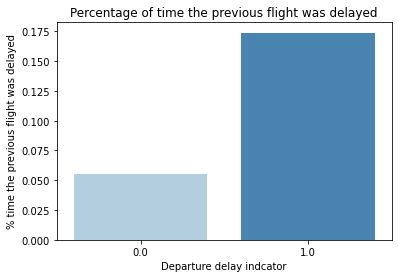

[Text(0.5, 1.0, 'Percentage of time the previous flight was delayed'),
 Text(0.5, 0, 'Departure delay indcator'),
 Text(0, 0.5, '% time the previous flight was delayed')]

In [0]:
sns.barplot(data = pd_timebased, x = 'DEP_DEL15', y = 'PCT_PREV_DEL_15', palette='Blues').set(title = 'Percentage of time the previous flight was delayed', xlabel = 'Departure delay indcator', ylabel = '% time the previous flight was delayed')
plt.show()

### EDA 4: Exploring occurances of null values in weather data

In [0]:
df_train1 = spark.read.parquet(f"{blob_url}/train_agg_0404")

In [0]:
import numpy as np

# Percentage of delayed and non delayed flights in grouped variables
ratios = []
features = ['WND_Speed_mean','TMP_Value_mean','SLP_Value_mean']

for feature in features:
    df_tmp = df_train1.select(feature, "DEP_DEL15").filter(~F.col(feature).isNull()) 
    nd = df_tmp.where(df_tmp['DEP_DEL15'] == 0).count() #19590517 
    de = df_tmp.where(df_tmp['DEP_DEL15'] == 1).count() #4316380
    df_tmp_null = df_train1.select(feature, "DEP_DEL15").filter(F.col(feature).isNull()) #21%, 22% for without null
    tmp_null_nd = df_tmp_null.where(df_tmp_null.DEP_DEL15 == 0).count() #55,724, 19590517 
    tmp_null_del= df_tmp_null.where(df_tmp_null.DEP_DEL15 == 1).count() #14,997, 4316380

#     print(f"{nd}")
#     print(f"{de}")
    
#     print(f"{tmp_null_nd}")
#     print(f"{tmp_null_del}")
    if nd==0:
        ratio_nd=0
        print(f"{nd} non delayed count, {tmp_null_nd} nulls")
    else:
        ratio_nd = tmp_null_nd/nd
    
    if de==0:
        ratio_del=0
        print(f"{de} non delayed count, {tmp_null_del} nulls")
    else:
        ratio_del = tmp_null_del/de

    print(f"{feature}: Ratio non-delayed: {ratio_nd:.3f} - delayed {ratio_del:.3f}")

WND_Speed_mean: Ratio non-delayed: 0.003 - delayed 0.003
TMP_Value_mean: Ratio non-delayed: 0.003 - delayed 0.003
SLP_Value_mean: Ratio non-delayed: 0.004 - delayed 0.005

## EDA 5: Exploring flights by year

In [0]:
all_flights = get_full_airlines_data_train().union(get_full_airlines_data_test())
df_all_flights_yearly = all_flights.groupBy("YEAR").agg((F.avg("DEP_DEL15") * 100).alias("PCT_DELAYED"), F.count('*').alias('TOTAL_FLIGHTS')).orderBy("YEAR").cache()
pd_all_flights_yearly = df_all_flights_yearly.toPandas()

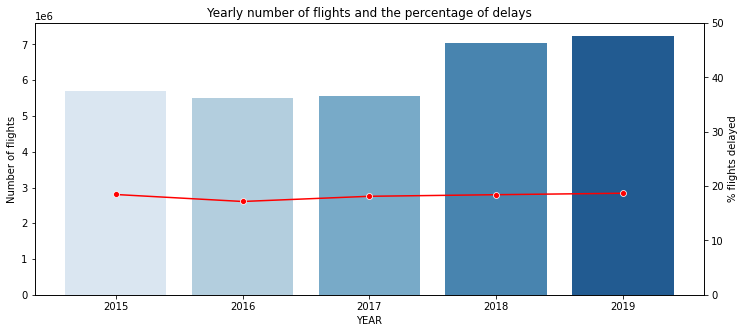

In [0]:
fig, axis = plt.subplots(1,1, figsize=(12,5))
sns.barplot(ax = axis, data=pd_all_flights_yearly, x='YEAR', y='TOTAL_FLIGHTS', palette='Blues').set(ylabel = "Number of flights")
axis2 = axis.twinx() 
sns.lineplot(ax = axis2, data=pd_all_flights_yearly, x='YEAR', y='PCT_DELAYED', color='red', marker='o').set(title = "Yearly number of flights and the percentage of delays", xlabel = "Year", ylabel = "% flights delayed")
plt.ylim((0,50))
plt.show()

## EDA 6: Exploring flights by week day
Only based on training data

Out[16]:

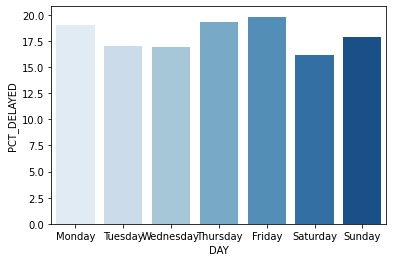

<AxesSubplot:xlabel='DAY', ylabel='PCT_DELAYED'>

In [0]:
# Day of the week - Monday is 1
import calendar 

get_day_name = udf(lambda day_num: calendar.day_name[day_num - 1])


flight_delays_by_day = airlines_train.groupBy(["DAY_OF_WEEK"]).agg((F.avg("DEP_DEL15") * 100).alias("PCT_DELAYED")) \
                                .withColumn("DAY", get_day_name(airlines_train["DAY_OF_WEEK"])) \
                                .orderBy("DAY_OF_WEEK")

pd_flight_delays_by_day = flight_delays_by_day.toPandas()



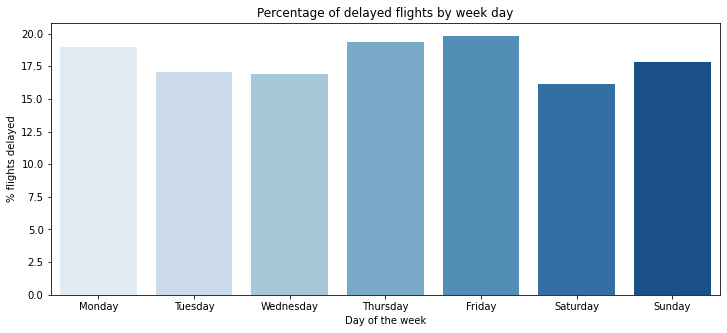

In [0]:
fig, axis = plt.subplots(1,1, figsize=(12,5))
sns.barplot(ax = axis, data=pd_flight_delays_by_day, x='DAY', y='PCT_DELAYED', palette='Blues').set(title = "Percentage of delayed flights by week day", xlabel = "Day of the week", ylabel = "% flights delayed")

plt.show()

## EDA 7: Exploring flights by flight distance, airline carrier and time of day of departure

In [0]:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[ 0, 900, 1200, 1600, 2000, 2359],inputCol="CRS_DEP_TIME", outputCol="CRS_DEP_BUCKET")
airlines_train = bucketizer.transform(airlines_train)

In [0]:
cat_cols = ["DISTANCE_GROUP","OP_UNIQUE_CARRIER", "CRS_DEP_BUCKET"]
df_distance_group = airlines_train.groupBy("DISTANCE_GROUP").agg(F.count("DISTANCE_GROUP"), F.avg("DEP_DEL15")).cache()
pd_distance_group = df_distance_group.toPandas()
df_carrier = airlines_train.groupBy("OP_UNIQUE_CARRIER").agg(F.count("OP_UNIQUE_CARRIER"), F.avg("DEP_DEL15")).cache()
pd_carrier = df_carrier.toPandas()
df_dep_bucket = airlines_train.groupBy("CRS_DEP_BUCKET").agg(F.count("CRS_DEP_BUCKET"), F.avg("DEP_DEL15")).cache()
pd_dep_bucket = df_dep_bucket.toPandas()

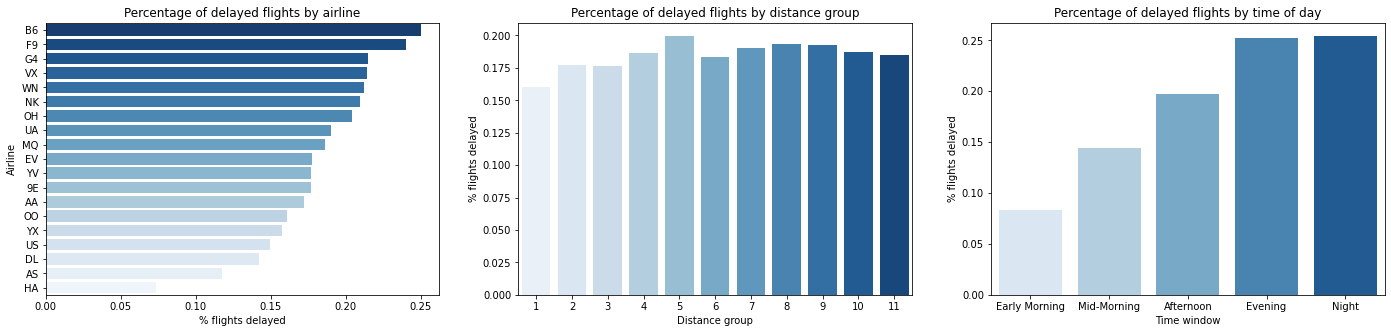

In [0]:
import numpy as np
fig, axis = plt.subplots(1,3, figsize=(24,5))
pd_distance_group = pd_distance_group.astype({'DISTANCE_GROUP': 'int32'}).sort_values('DISTANCE_GROUP')
sns.barplot(ax=axis[0], data=pd_carrier.sort_values('avg(DEP_DEL15)', ascending=False), y='OP_UNIQUE_CARRIER', x='avg(DEP_DEL15)', palette='Blues_r').set(title = "Percentage of delayed flights by airline", ylabel = "Airline", xlabel = "% flights delayed")
sns.barplot(ax=axis[1], data=pd_distance_group, x='DISTANCE_GROUP', y='avg(DEP_DEL15)', palette='Blues').set(title = "Percentage of delayed flights by distance group", xlabel = "Distance group", ylabel = "% flights delayed")
sns.barplot(ax=axis[2], data=pd_dep_bucket, x='CRS_DEP_BUCKET', y='avg(DEP_DEL15)', palette='Blues').set(title = "Percentage of delayed flights by time of day", xlabel = "Time window", ylabel = "% flights delayed")
plt.xticks(np.arange(5), ('Early Morning', 'Mid-Morning', 'Afternoon', 'Evening', 'Night'))
plt.show()

## EDA 8: Weather Conditions and Delays

In [0]:
# Using 2015 data only as it is too large to visualize otherwise
df_2015 = spark.read.parquet(f"{blob_url}/join_full_0329").filter(F.col("YEAR") == '2015').cache()


In [0]:
%run "./libs/weather_aggregation"

In [0]:
df_2015_aggregated = aggregate_weather_reports(df_2015).cache()

Getting a rough sense of correlation between numerical weather features and outcome variable using mean and stdv:

In [0]:
display(df_2015_aggregated.groupBy('DEP_DEL15').agg(
    F.mean(col('TMP_Value') / 10).alias('TMP_avg'), F.stddev(col('TMP_Value') / 10).alias('TMP_stdv'), \
    F.mean(col('DEW_Value')).alias('DEW_avg'), F.stddev(col('DEW_Value')).alias('DEW_stdv'), \
    F.mean(col('VIS_Horizontal')).alias('VIS_Horizontal_avg'), F.stddev(col('VIS_Horizontal')).alias('VIS_Horizontal_stdv'), \
    F.mean(col('WND_Speed')).alias('WND_Speed_avg'), F.stddev(col('WND_Speed')).alias('WND_Speed_stdv'), \
    F.mean(col('SLP_Value')).alias('SLP_Value_avg'), F.stddev(col('SLP_Value')).alias('SLP_Value_stdv'), \
    F.mean(col('AA_RainDepth')).alias('AA_RainDepth_avg'), F.stddev(col('AA_RainDepth')).alias('AA_RainDepth_stdv'), \
    F.mean(col('AA_RainDuration')).alias('AA_RainDuration_avg'), F.stddev(col('AA_RainDuration')).alias('AA_RainDuration_stdv'), \
    F.mean(col('AL_SnowAccumDuration')).alias('AL_SnowAccumDuration_avg'), F.stddev(col('AL_SnowAccumDuration')).alias('AL_SnowAccumDuration_stdv'), \
    F.mean(col('AL_SnowAccumDepth')).alias('AL_SnowAccumDepth_avg'), F.stddev(col('AL_SnowAccumDepth')).alias('AL_SnowAccumDepth_stdv'), \
    F.mean(col('AJ1_SnowDepth')).alias('AJ1_SnowDepth_avg'), F.stddev(col('AJ1_SnowDepth')).alias('AJ1_SnowDepth_stdv'), \
    F.mean(col('AJ1_SnowEqWaterDepth')).alias('AJ1_SnowEqWaterDepth_avg'), F.stddev(col('AJ1_SnowEqWaterDepth')).alias('AJ1_SnowEqWaterDepth_stdv'), \
    F.mean(col('WND_Speed')).alias('WND_Speed_avg'), F.stddev(col('WND_Speed')).alias('WND_Speed_stdv'), \
    F.mean(col('WND_DirectionAngle')).alias('WND_DirectionAngle_avg'), F.stddev(col('WND_DirectionAngle')).alias('WND_DirectionAngle_stdv'), \
    F.mean(col('CIG_CeilingHeightDim')).alias('CIG_CeilingHeightDim_avg'), F.stddev(col('CIG_CeilingHeightDim')).alias('CIG_CeilingHeightDim_stdv'), \
    ))

DEP_DEL15 TMP_avg TMP_stdv DEW_avg DEW_stdv VIS_Horizontal_avg VIS_Horizontal_stdv WND_Speed_avg WND_Speed_stdv SLP_Value_avg SLP_Value_stdv AA_RainDepth_avg AA_RainDepth_stdv AA_RainDuration_avg AA_RainDuration_stdv AL_SnowAccumDuration_avg AL_SnowAccumDuration_stdv AL_SnowAccumDepth_avg AL_SnowAccumDepth_stdv AJ1_SnowDepth_avg AJ1_SnowDepth_stdv AJ1_SnowEqWaterDepth_avg AJ1_SnowEqWaterDepth_stdv WND_Speed_avg WND_Speed_stdv WND_DirectionAngle_avg WND_DirectionAngle_stdv CIG_CeilingHeightDim_avg CIG_CeilingHeightDim_stdv 0.0 15.353561833137062 9.809305988590706 87.73311922672187 100.6393723405869 14927.17871872119 2946.5796155918188 33.01437296420831 20.680416697470932 10168.782483330468 66.00814780456844 42.24505312948858 74.80033995743945 2.635675717331875 2.535021118983562 23.780911367519366 2.234089419248116 2.386151672504558 2.1524999323501173 1.5288573547437714 5.559111948896403 1066.7997239593744 1107.0088611734077 33.01437296420831 20.680416697470932 190.64314925785087 87.6110784666034 12847.101741479772 8751.50943909968 1.0 15.032379803159083 11.160801633862338 88.53707444604548 111.4136298707272 14296.48775063053 3685.205579830815 35.47846351524445 21.790621721412286 10167.256611139084 67.97536584427996 41.74294888261388 72.81956518600364 2.474150537405281 2.4047951704243986 22.836575875486382 5.040663517790181 3.0845099090572083 3.241220562415238 3.3161759636653763 7.816058924973332 1241.6570242823884 1109.6676976589963 35.47846351524445 21.790621721412286 190.24985949873135 86.07989283323506 11055.455990850593 8893.953796837279

In [0]:
# Converting to pandas only to be able to do better visualization
pd_2015 = df_2015_aggregated.toPandas()

In [0]:
num_delayed_flights_agg = df_2015_aggregated.filter(F.col('DEP_DEL15') == 1).count()
num_not_delayed_flights_agg = df_2015_aggregated.filter(F.col('DEP_DEL15') == 0).count()
window_condition = Window.partitionBy(['DEP_DEL15']).orderBy(F.desc('count'))
weather_cond_delays = df_2015_aggregated.groupBy('DEP_DEL15', 'AW1_PresentWeatherCond').count().withColumn('pct', F.when(F.col('DEP_DEL15') == 1, F.col('count') / num_delayed_flights_agg).otherwise(F.col('count') / num_not_delayed_flights_agg)).withColumn("Rank", F.row_number().over(window_condition)).filter(F.col("Rank") <= 5)

In [0]:
pd_weather_cond_delays = weather_cond_delays.drop('count').filter(col('AW1_PresentWeatherCond').isNotNull()).toPandas() 

In [0]:
colors = sns.color_palette("Blues", n_colors=4)
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)
weather_cond_pivot = pd_weather_cond_delays.pivot(index='DEP_DEL15', columns=['AW1_PresentWeatherCond'], values='pct')
weather_cond_pivot.plot(kind='bar', colormap=cmap1).set(xlabel='Delay indicator', ylabel='Occurance percentage', title='Top 4 weather conditions for delayed and non-delayed flights ')
leg = plt.legend()
leg.get_texts()[0].set_text('Mist')
leg.get_texts()[1].set_text('Smoke')
leg.get_texts()[2].set_text('Rain, not freezing, slight')
leg.get_texts()[3].set_text('Snow, slight')

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1858507102427270> in <module> 
 1 colors = sns . color_palette ( "Blues" , n_colors = 4 ) 
 ----> 2 cmap1 = LinearSegmentedColormap . from_list ( "my_colormap" , colors ) 
 3 weather_cond_pivot = pd_weather_cond_delays . pivot ( index = 'DEP_DEL15' , columns = [ 'AW1_PresentWeatherCond' ] , values = 'pct' ) 
 4 weather_cond_pivot . plot ( kind = 'bar' , colormap = cmap1 ) . set ( xlabel = 'Delay indicator' , ylabel = 'Occurance percentage' , title = 'Top 4 weather conditions for delayed and non-delayed flights ' ) 
 5 leg = plt . legend ( ) 

 NameError : name 'LinearSegmentedColormap' is not defined

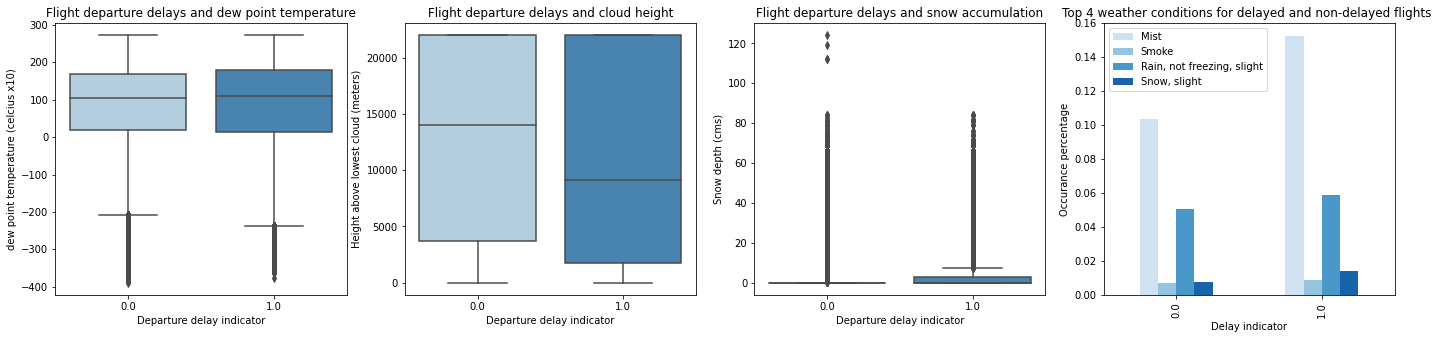

In [0]:
figure, axes = plt.subplots(1, 4, figsize=(24, 5))
sns.boxplot(ax=axes[0], data = pd_2015, x = 'DEP_DEL15', y = 'DEW_Value', palette='Blues').set(title = "Flight departure delays and dew point temperature", xlabel = "Departure delay indicator", ylabel = "dew point temperature (celcius x10)")
sns.boxplot(ax=axes[1], data = pd_2015, x = 'DEP_DEL15', y = 'CIG_CeilingHeightDim', palette='Blues').set(title = "Flight departure delays and cloud height", xlabel = "Departure delay indicator", ylabel = "Height above lowest cloud (meters)")
sns.boxplot(ax=axes[2], data = pd_2015, x = 'DEP_DEL15', y = 'AJ1_SnowDepth', palette='Blues').set(title = "Flight departure delays and snow accumulation", xlabel = "Departure delay indicator", ylabel = "Snow depth (cms)")

colors = sns.color_palette("Blues", n_colors=4)
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)
weather_cond_pivot = pd_weather_cond_delays.pivot(index='DEP_DEL15', columns=['AW1_PresentWeatherCond'], values='pct')
weather_cond_pivot.plot(ax = axes[3], kind='bar', colormap=cmap1).set(xlabel='Delay indicator', ylabel='Occurance percentage', title='Top 4 weather conditions for delayed and non-delayed flights ')
leg = plt.legend()
leg.get_texts()[0].set_text('Mist')
leg.get_texts()[1].set_text('Smoke')
leg.get_texts()[2].set_text('Rain, not freezing, slight')
leg.get_texts()[3].set_text('Snow, slight')

plt.show()

## EDA 9: Impact of airline hubs on departure delays

In [0]:
airlines_train = airlines_train.withColumn("UA_HUB_ORIG", F.when((airlines_train.ORIGIN == "ORD") | (airlines_train.ORIGIN == "DEN") | (airlines_train.ORIGIN == "IAH") | (airlines_train.ORIGIN == "LAX") | \
                                                   (airlines_train.ORIGIN == "EWR") | (airlines_train.ORIGIN == "SFO") | (airlines_train.ORIGIN == "IAD"), 1)
                                                 .otherwise(0)) \
                                  .withColumn("UA_HUB_DEST", F.when((airlines_train.DEST == "ORD") | (airlines_train.DEST == "DEN") | (airlines_train.DEST == "IAH") | (airlines_train.DEST == "LAX") | \
                                                   (airlines_train.DEST == "EWR") | (airlines_train.DEST == "SFO") | (airlines_train.DEST == "IAD"), 1)
                                                 .otherwise(0))
    




In [0]:
display(airlines_train.filter(airlines_train.OP_UNIQUE_CARRIER == "UA").groupBy("UA_HUB_ORIG").agg(F.avg(F.col("DEP_DEL15"))))

UA_HUB_ORIG avg(DEP_DEL15) 1 0.20937052604094875 0 0.15920620465723856

In [0]:
display(airlines_train.filter(airlines_train.OP_UNIQUE_CARRIER == "UA").groupBy("UA_HUB_DEST").agg(F.avg(F.col("DEP_DEL15"))))

UA_HUB_DEST avg(DEP_DEL15) 1 0.18163316683754072 0 0.20374480618524168

In [0]:
airlines_train = airlines_train.withColumn("B6_HUB_ORIG", F.when((airlines_train.ORIGIN == "JFK") | (airlines_train.ORIGIN == "BOS") | (airlines_train.ORIGIN == "FLL") | (airlines_train.ORIGIN == "LGB") | \
                                                   (airlines_train.ORIGIN == "MCO") | (airlines_train.ORIGIN == "SJU") , 1)
                                                 .otherwise(0)) \
                                  .withColumn("B6_HUB_DEST", F.when((airlines_train.DEST == "JFK") | (airlines_train.DEST == "BOS") | (airlines_train.DEST == "FLL") | (airlines_train.DEST == "LGB") | \
                                                   (airlines_train.DEST == "MCO") | (airlines_train.DEST == "SJU") , 1)
                                                 .otherwise(0))


In [0]:
display(airlines_train.filter(airlines_train.OP_UNIQUE_CARRIER == "B6").groupBy("B6_HUB_ORIG").agg(F.avg(F.col("DEP_DEL15"))))

B6_HUB_ORIG avg(DEP_DEL15) 1 0.2508646595702151 0 0.24920798103350608

In [0]:
display(airlines_train.filter(airlines_train.OP_UNIQUE_CARRIER == "B6").groupBy("B6_HUB_ORIG").agg(F.avg(F.col("DEP_DEL15"))))

B6_HUB_ORIG avg(DEP_DEL15) 1 0.2508854811324082 0 0.2491745303263538

## EDA 10: Correlation matrix (numeric features)

In [0]:
df_joined_clean = spark.read.parquet(f"{blob_url}/corr_eda_heatmap")

In [0]:
# Get numerical and categorical values
y_label = ['DEP_DEL15']
# categorical_cols = [t[0] for t in df_joined.dtypes if t[1] =='string']

non_catecorical_cols = [t[0] for t in df_joined_clean.dtypes if t[1] !='string']
non_catecorical_cols.remove(*y_label)

#### Correlation matrix

In [0]:
# non_catecorical_cols.remove("WND_Speed_mean")
non_catecorical_cols.remove("TIMESTAMP")

In [0]:
outcome = 'corr_features'

assembler = VectorAssembler(inputCols=non_catecorical_cols+["DEP_DEL15"], outputCol=outcome)

air_vector = assembler.transform(df_joined_clean).select(outcome)

matrix = Correlation.corr(air_vector, outcome,'pearson').collect()[0][0]

corrmatrix = np.round(matrix.toArray(),3).tolist()

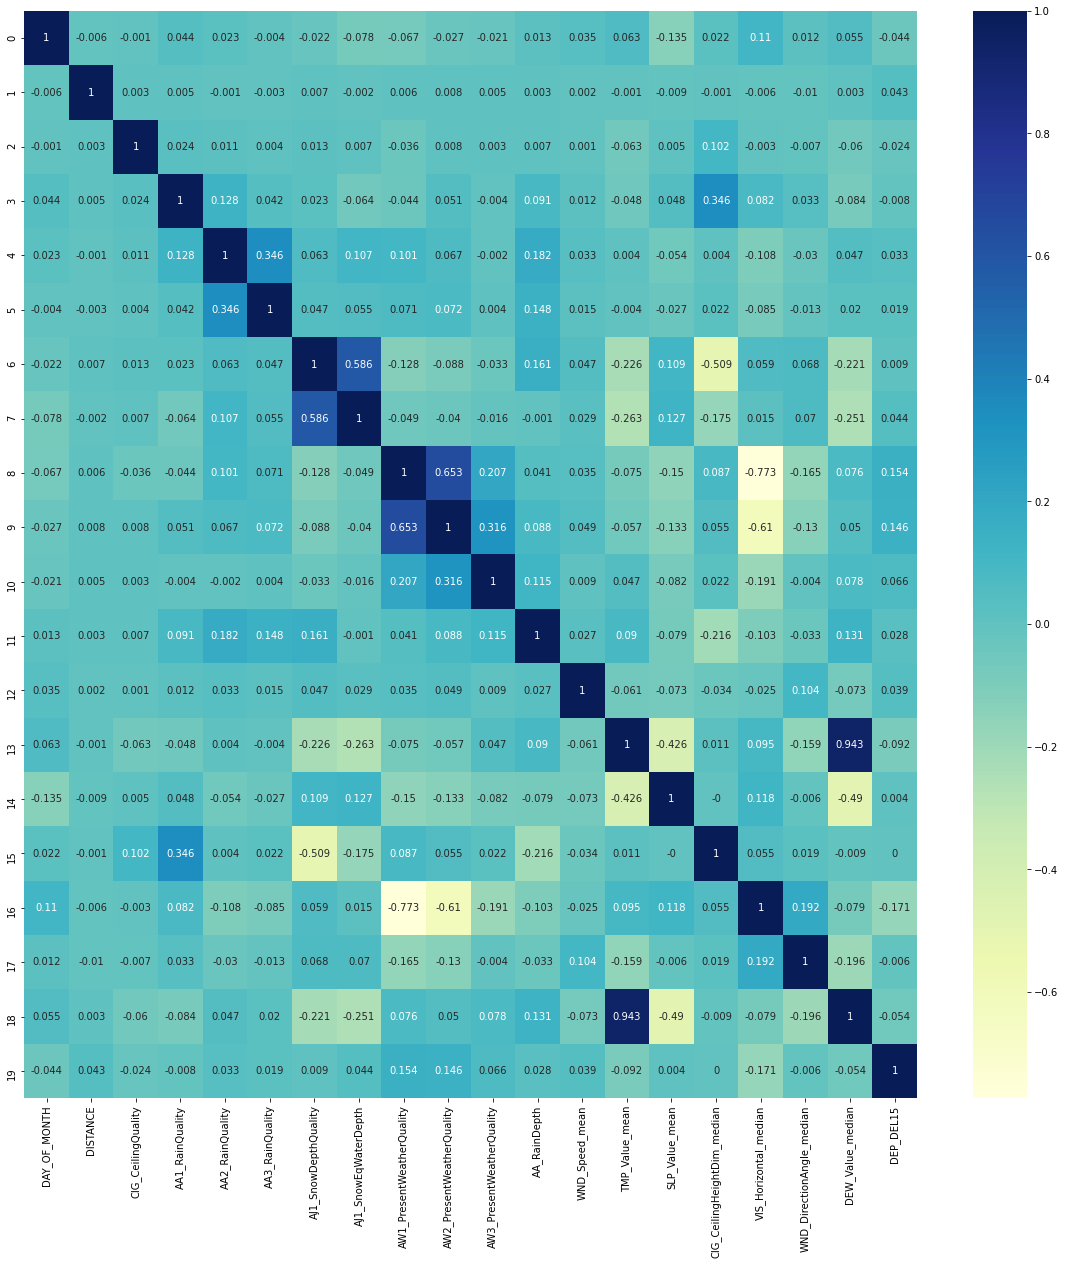

In [0]:
# plot the heat map
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrmatrix, annot=True, fmt="g", cmap="YlGnBu", ax=ax, xticklabels=non_catecorical_cols+['DEP_DEL15'])
plt.show()

## EDA 11: Feature importance of categorical variables

#### Split into train and test

In [0]:
train = df_joined.filter((df_joined.MONTH < 5) | ((df_joined.MONTH==5) & (df_joined.DAY_OF_MONTH <= 15)))
test = df_joined.filter((df_joined.MONTH == 6) | ((df_joined.MONTH==5) & (df_joined.DAY_OF_MONTH > 15)))

In [0]:
y_label = ['DEP_DEL15']
categorical_cols = [t[0] for t in df_joined.dtypes if t[1] =='string']
categorical_cols.remove("iata_code")

In [0]:
indexers=[]
new_categorical_cols=[]
for feature in categorical_cols:
    indexers.append(StringIndexer(inputCol=feature, outputCol=f"{feature}_indexed", stringOrderType='frequencyAsc', handleInvalid="keep"))
    new_categorical_cols.append(f"{feature}_indexed")
    
#Fits a model to the input dataset with optional parameters.
pipeline = Pipeline(stages=indexers)
train = pipeline.fit(train).transform(train).drop(*categorical_cols)
test = pipeline.fit(test).transform(test).drop(*categorical_cols)

In [0]:
x_train = train
x_test = test

In [0]:
new_categorical_cols =new_categorical_cols+['DEP_DEL15']
# new_categorical_cols

Out[214]: ['ARR_DELAY_GROUP_indexed',
 'ARR_TIME_BLK_indexed',
 'CRS_DEP_TIME_indexed',
 'DEP_DELAY_GROUP_indexed',
 'DEP_TIME_BLK_indexed',
 'DEST_indexed',
 'DEST_AIRPORT_ID_indexed',
 'DEST_AIRPORT_SEQ_ID_indexed',
 'DEST_CITY_MARKET_ID_indexed',
 'DEST_CITY_NAME_indexed',
 'DEST_STATE_ABR_indexed',
 'DEST_STATE_NM_indexed',
 'DISTANCE_GROUP_indexed',
 'FL_DATE_indexed',
 'MONTH_indexed',
 'OP_CARRIER_indexed',
 'OP_CARRIER_AIRLINE_ID_indexed',
 'OP_CARRIER_FL_NUM_indexed',
 'OP_UNIQUE_CARRIER_indexed',
 'ORIGIN_indexed',
 'ORIGIN_AIRPORT_SEQ_ID_indexed',
 'ORIGIN_CITY_MARKET_ID_indexed',
 'ORIGIN_CITY_NAME_indexed',
 'ORIGIN_STATE_ABR_indexed',
 'ORIGIN_STATE_NM_indexed',
 'QUARTER_indexed',
 'TAIL_NUM_indexed',
 'YEAR_indexed',
 'ident_indexed',
 'elevation_ft_indexed',
 'coordinates_indexed',
 'station_id_indexed',
 'neighbor_id_indexed',
 'neighbor_name_indexed',
 'neighbor_state_indexed',
 'neighbor_call_indexed',
 'STATION_indexed',
 'NAME_indexed',
 'REPORT_TYPE_indexed',
 'CALL_SIGN_indexed',
 'QUALITY_CONTROL_indexed',
 'WND_Type_indexed',
 'CIG_CeilingDetermination_indexed',
 'CIG_CeilingAndVisibilityOK_indexed',
 'VIS_Variability_indexed',
 'AA1_RainCondition_indexed',
 'AA2_RainCondition_indexed',
 'AA3_RainCondition_indexed',
 'AA4_RainCondition_indexed',
 'AJ1_SnowDepthCondition_indexed',
 'AJ1_SnowEqWaterDepthCondition_indexed',
 'AL1_SnowAccumCondition_indexed',
 'AL2_SnowAccumCondition_indexed',
 'AL3_SnowAccumCondition_indexed',
 'AA_RainDepth_indexed',
 'AL_SnowAccumDepth_indexed',
 'AA_RainDuration_indexed',
 'AL_SnowAccumDuration_indexed',
 'DEP_DEL15']

In [0]:
x_train=x_train.select(*new_categorical_cols)
x_test=x_test.select(*new_categorical_cols)

In [0]:
x_train=x_train.withColumnRenamed("DEP_DEL15","label")
x_test=x_test.withColumnRenamed("DEP_DEL15","label")

In [0]:
new_categorical_cols.remove("DEP_DEL15")

In [0]:
for feature in new_categorical_cols:
    print(f"feature: {feature} - {x_train.select(feature).distinct().count()} of {x_train.select(feature).count()}")

feature: ARR_DELAY_GROUP_indexed - 16 of 4919708
feature: ARR_TIME_BLK_indexed - 19 of 4919708
feature: CRS_DEP_TIME_indexed - 1030 of 4919708
feature: DEP_DELAY_GROUP_indexed - 15 of 4919708
feature: DEP_TIME_BLK_indexed - 19 of 4919708
feature: DEST_indexed - 194 of 4919708
feature: DEST_AIRPORT_ID_indexed - 194 of 4919708
feature: DEST_AIRPORT_SEQ_ID_indexed - 201 of 4919708
feature: DEST_CITY_MARKET_ID_indexed - 177 of 4919708
feature: DEST_CITY_NAME_indexed - 190 of 4919708
feature: DEST_STATE_ABR_indexed - 51 of 4919708
feature: DEST_STATE_NM_indexed - 51 of 4919708
feature: DISTANCE_GROUP_indexed - 10 of 4919708
feature: FL_DATE_indexed - 135 of 4919708
feature: MONTH_indexed - 5 of 4919708
feature: OP_CARRIER_indexed - 13 of 4919708
feature: OP_CARRIER_AIRLINE_ID_indexed - 13 of 4919708
feature: OP_CARRIER_FL_NUM_indexed - 4263 of 4919708
feature: OP_UNIQUE_CARRIER_indexed - 13 of 4919708
feature: ORIGIN_indexed - 2 of 4919708
feature: ORIGIN_AIRPORT_SEQ_ID_indexed - 2 of 4919708
feature: ORIGIN_CITY_MARKET_ID_indexed - 2 of 4919708
feature: ORIGIN_CITY_NAME_indexed - 2 of 4919708
feature: ORIGIN_STATE_ABR_indexed - 2 of 4919708
feature: ORIGIN_STATE_NM_indexed - 2 of 4919708
feature: QUARTER_indexed - 2 of 4919708
feature: TAIL_NUM_indexed - 4069 of 4919708
feature: YEAR_indexed - 1 of 4919708
feature: ident_indexed - 2 of 4919708
feature: elevation_ft_indexed - 2 of 4919708
feature: coordinates_indexed - 2 of 4919708
feature: station_id_indexed - 7 of 4919708
feature: neighbor_id_indexed - 2 of 4919708
feature: neighbor_name_indexed - 2 of 4919708
feature: neighbor_state_indexed - 2 of 4919708
feature: neighbor_call_indexed - 2 of 4919708
feature: STATION_indexed - 2 of 4919708
feature: NAME_indexed - 2 of 4919708
feature: REPORT_TYPE_indexed - 6 of 4919708
feature: CALL_SIGN_indexed - 3 of 4919708
feature: QUALITY_CONTROL_indexed - 2 of 4919708
feature: WND_Type_indexed - 3 of 4919708
feature: CIG_CeilingDetermination_indexed - 4 of 4919708
feature: CIG_CeilingAndVisibilityOK_indexed - 2 of 4919708
feature: VIS_Variability_indexed - 3 of 4919708
feature: AA1_RainCondition_indexed - 4 of 4919708
feature: AA2_RainCondition_indexed - 4 of 4919708
feature: AA3_RainCondition_indexed - 4 of 4919708
feature: AA4_RainCondition_indexed - 1 of 4919708
feature: AJ1_SnowDepthCondition_indexed - 3 of 4919708
feature: AJ1_SnowEqWaterDepthCondition_indexed - 2 of 4919708
feature: AL1_SnowAccumCondition_indexed - 1 of 4919708
feature: AL2_SnowAccumCondition_indexed - 1 of 4919708
feature: AL3_SnowAccumCondition_indexed - 1 of 4919708
feature: AA_RainDepth_indexed - 194 of 4919708
feature: AL_SnowAccumDepth_indexed - 1 of 4919708
feature: AA_RainDuration_indexed - 9 of 4919708
feature: AL_SnowAccumDuration_indexed - 1 of 4919708

In [0]:
new_categorical_cols.remove("CRS_DEP_TIME_indexed")
new_categorical_cols.remove("DEST_indexed")
new_categorical_cols.remove("DEST_AIRPORT_ID_indexed")
new_categorical_cols.remove("DEST_AIRPORT_SEQ_ID_indexed")
new_categorical_cols.remove("DEST_CITY_MARKET_ID_indexed")
new_categorical_cols.remove("DEST_CITY_NAME_indexed")
new_categorical_cols.remove("DEST_STATE_NM_indexed")
new_categorical_cols.remove("FL_DATE_indexed")
new_categorical_cols.remove("OP_CARRIER_FL_NUM_indexed")
new_categorical_cols.remove("AA_RainDepth_indexed")
new_categorical_cols.remove("TAIL_NUM_indexed")
new_categorical_cols.remove("DEST_STATE_ABR_indexed")

In [0]:
new_categorical_cols[4]

Out[228]: 'DEST_STATE_ABR_indexed'

In [0]:

# Assemble the vector and run a decision tree
outcome='indexed_categories'
assembler = VectorAssembler(inputCols=new_categorical_cols, outputCol=outcome)

# Let's use random forest to find feature importance of categorical features
rf = RandomForestRegressor(featuresCol=outcome,
                           maxDepth=2,
                           numTrees=2,
                           maxBins=38,
                           labelCol='label',
#                            n_jobs=-1,
#                            oob_score=True,
                          bootstrap=True)

pipeline = Pipeline(stages=[assembler, rf])

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 3, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)


cvModel = crossval.fit(x_train)
predictions = cvModel.transform(x_test)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

Out[231]:

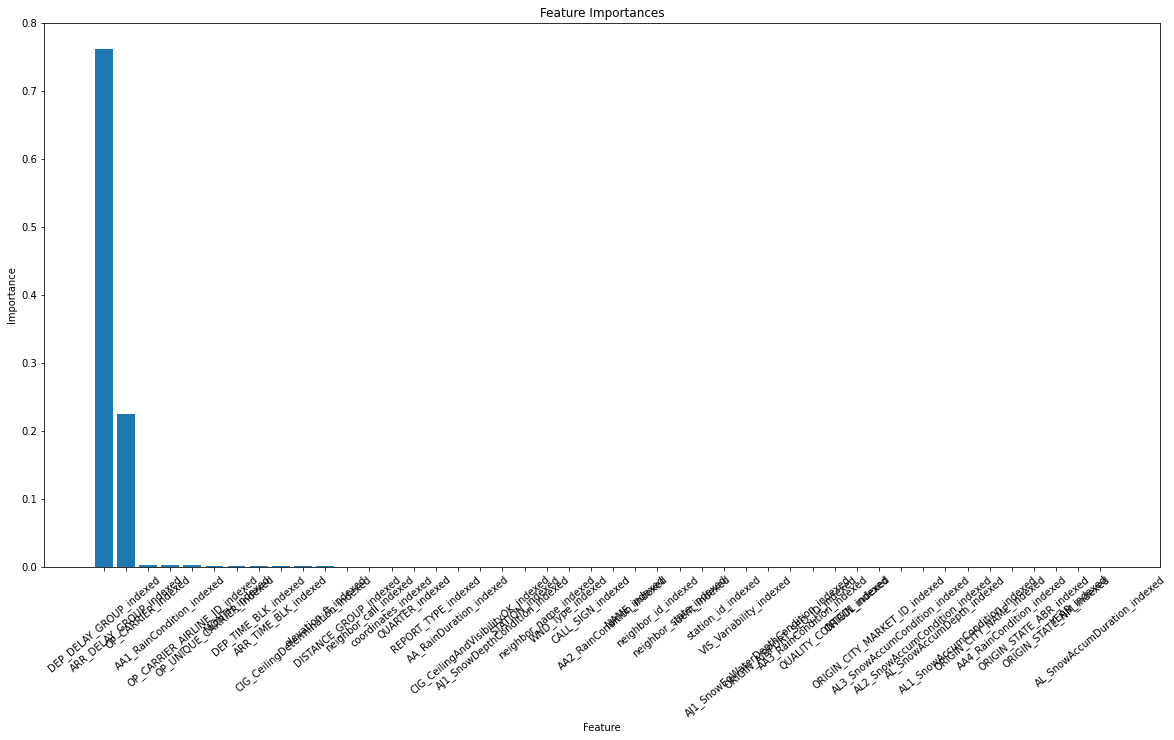

Text(0.5, 1.0, 'Feature Importances')

In [0]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances

sorted_indices = np.argsort(importances)[::-1]
sorted_importances = [importances[int(ix)] for ix in sorted_indices]
sorted_features = [new_categorical_cols[int(ix)] for ix in sorted_indices]

x_values = list(range(len(importances)))


fig, ax = plt.subplots(figsize=(20,10))

plt.bar(x_values, sorted_importances, orientation = 'vertical')
plt.xticks(x_values, sorted_features, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')